### Edgar Moises Hernandez-Gonzalez
#### 09/04/20-11/04/20
#### Clasificacion de imagenes motoras en EEG con Fine Tuning
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical

##### VGG16
##### Sujeto 1
##### Accuracy = 50.00%
##### Kappa = 0.3333

##### InceptionV3
##### Sujeto 1
##### Accuracy = 50.00%
##### Kappa = 0.3333

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [7]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [8]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [9]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (299, 299) #ancho, alto
  fs = 250
  datos = np.zeros((288,299,299,3))
  temporal = np.zeros((528,4,3))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :, 0] = Sxx[8:32, :]
      temporal[j*24:(j+1)*24, :, 1] = Sxx[8:32, :]
      temporal[j*24:(j+1)*24, :, 2] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
  return datos

In [0]:
#llamar a unir_espectrogramas_vertical_resize(data)
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

In [12]:
print(x_train.shape)
print(x_test.shape)

(288, 299, 299, 3)
(288, 299, 299, 3)


In [13]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

124.52351832617315
88.18918136153654
0.0006962254188471109
0.00013698288039382033
1.171795813706635
1.1849465019572498


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 125.0
x_test /= 125.0

In [15]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.99618816
0.7055134
5.5698033e-06
1.095863e-06
0.009374359
0.009479575


In [0]:
base_model = InceptionV3(weights='imagenet',
                         include_top=False,
                         input_shape=x_train.shape[1:])

In [0]:
# operación global de agrupación máxima para datos espaciales.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
# entrenar solo las capas superiores (top) que se inicializaron aleatoriamente
# congelar todas las capas convolucionales de InceptionV3
for layer in base_model.layers:
    layer.trainable = False

In [0]:
# debe hacerse después de configurar las capas como no entrenables
model.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

Iteration: 1
Epoch 1/40
16/16 - 7s - loss: 1.6072 - accuracy: 0.2708 - val_loss: 1.2890 - val_accuracy: 0.3056
Epoch 2/40
16/16 - 6s - loss: 1.3199 - accuracy: 0.3715 - val_loss: 1.3198 - val_accuracy: 0.3611
Epoch 3/40
16/16 - 6s - loss: 1.2785 - accuracy: 0.4236 - val_loss: 1.2405 - val_accuracy: 0.3924
Epoch 4/40
16/16 - 6s - loss: 1.2715 - accuracy: 0.3993 - val_loss: 1.2410 - val_accuracy: 0.3854
Epoch 5/40
16/16 - 6s - loss: 1.2062 - accuracy: 0.4340 - val_loss: 1.2684 - val_accuracy: 0.3646
Epoch 6/40
16/16 - 6s - loss: 1.1970 - accuracy: 0.4618 - val_loss: 1.1947 - val_accuracy: 0.3993
Epoch 7/40
16/16 - 6s - loss: 1.1877 - accuracy: 0.4306 - val_loss: 1.2569 - val_accuracy: 0.3611
Epoch 8/40
16/16 - 6s - loss: 1.1584 - accuracy: 0.4479 - val_loss: 1.2563 - val_accuracy: 0.4410
Epoch 9/40
16/16 - 6s - loss: 1.1722 - accuracy: 0.4688 - val_loss: 1.1924 - val_accuracy: 0.3819
Epoch 10/40
16/16 - 6s - loss: 1.0905 - accuracy: 0.4931 - val_loss: 1.1660 - val_accuracy: 0.4236
Epoch 

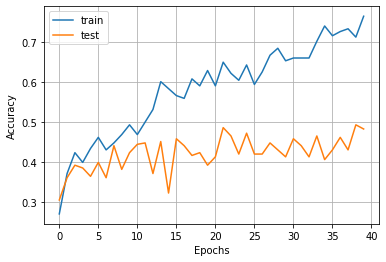

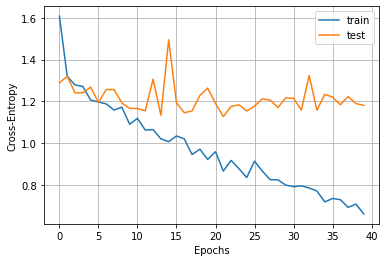


Resultados:
loss: [1.180938720703125]
accuracy: [0.4826388955116272]
kappa: [0.31018518518518523]


In [29]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(1):
  print("Iteration:", i+1)

  history = model.fit(x_train, y_train, epochs=40, batch_size=18,
                      validation_data=(x_test, y_test), verbose=2)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [30]:
# en este punto las capas superiores (top) estan entrenadas
# podemos empezar a ajustar el fine tuning
# congelaremos n capas inferiores (bottom)
# entrenar las capas superiores (top) restantes
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_2
1 conv2d_94
2 batch_normalization_94
3 activation_94
4 conv2d_95
5 batch_normalization_95
6 activation_95
7 conv2d_96
8 batch_normalization_96
9 activation_96
10 max_pooling2d_4
11 conv2d_97
12 batch_normalization_97
13 activation_97
14 conv2d_98
15 batch_normalization_98
16 activation_98
17 max_pooling2d_5
18 conv2d_102
19 batch_normalization_102
20 activation_102
21 conv2d_100
22 conv2d_103
23 batch_normalization_100
24 batch_normalization_103
25 activation_100
26 activation_103
27 average_pooling2d_9
28 conv2d_99
29 conv2d_101
30 conv2d_104
31 conv2d_105
32 batch_normalization_99
33 batch_normalization_101
34 batch_normalization_104
35 batch_normalization_105
36 activation_99
37 activation_101
38 activation_104
39 activation_105
40 mixed0
41 conv2d_109
42 batch_normalization_109
43 activation_109
44 conv2d_107
45 conv2d_110
46 batch_normalization_107
47 batch_normalization_110
48 activation_107
49 activation_110
50 average_pooling2d_10
51 conv2d_106
52 conv2d_108
53 conv2d

In [0]:
# entrenar los 2 bloques de inicio principales
# congelaremos las primeras 249 capas y descongelaremos el resto
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [0]:
# recompilar el modelo
model.compile(optimizer = SGD(lr=1e-6, momentum=0.9), #lr=0.0001, momentum=0.9
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

Iteration: 1
Epoch 1/400
16/16 - 8s - loss: 4.3508 - accuracy: 0.2500 - val_loss: 1.2881 - val_accuracy: 0.4444
Epoch 2/400
16/16 - 6s - loss: 4.2436 - accuracy: 0.2535 - val_loss: 1.6186 - val_accuracy: 0.3472
Epoch 3/400
16/16 - 6s - loss: 4.1568 - accuracy: 0.2500 - val_loss: 1.9896 - val_accuracy: 0.3125
Epoch 4/400
16/16 - 6s - loss: 4.0809 - accuracy: 0.2604 - val_loss: 2.2390 - val_accuracy: 0.2708
Epoch 5/400
16/16 - 6s - loss: 3.9916 - accuracy: 0.2535 - val_loss: 2.3754 - val_accuracy: 0.2569
Epoch 6/400
16/16 - 6s - loss: 3.9628 - accuracy: 0.2569 - val_loss: 2.4567 - val_accuracy: 0.2639
Epoch 7/400
16/16 - 6s - loss: 3.8424 - accuracy: 0.2535 - val_loss: 2.5288 - val_accuracy: 0.2569
Epoch 8/400
16/16 - 6s - loss: 3.7699 - accuracy: 0.2535 - val_loss: 2.5982 - val_accuracy: 0.2569
Epoch 9/400
16/16 - 6s - loss: 3.7019 - accuracy: 0.2535 - val_loss: 2.6623 - val_accuracy: 0.2569
Epoch 10/400
16/16 - 6s - loss: 3.6341 - accuracy: 0.2604 - val_loss: 2.7165 - val_accuracy: 0.2

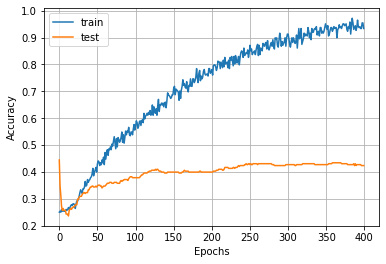

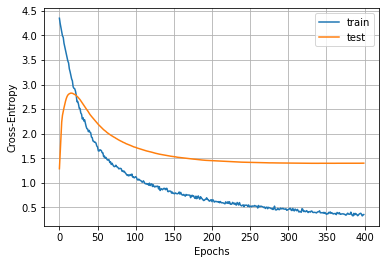


Resultados:
loss: [1.4010666608810425]
accuracy: [0.4236111044883728]
kappa: [0.2314814814814815]


In [33]:
# entrenamos nuestro modelo nuevamente
# fine tuning a 2 bloques (top) superiores de inception
# y a las capas superiores (top)
array_loss = []
array_acc = []
array_kappa = []
for i in range(1):
  print("Iteration:", i+1)

  history = model.fit(x_train, y_train, epochs=400, batch_size=18,
                      validation_data=(x_test, y_test), verbose=2)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [35]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [36]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.4236
std: (+/- 0.0000)
Mean Kappa: 0.2315
std: (+/- 0.0000)
Max Accuracy: 0.4236
Max Kappa: 0.2315
